# Model training

This notebook aims at illustrating the way we can train simple neural network models in current framework.

`Mapillary` data will be used as an illustration of this process. Some details about the [dataset labels](./1b_mapillary-label-analysis.ipynb), as well as about the [dataset creation](./1a_mapillary-dataset-presentation.ipynb), are available in previous notebooks.

Moreover the model of interest here will be *semantic segmentation*. To get some more details about model handling, please refer to [model creation notebook](./3_neural-network-model-creation.ipynb).

## Introduction

As usual, some dependencies must be loaded before to begin:

In [2]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras import backend, callbacks
import matplotlib.pyplot as plt

%matplotlib inline

/home/rde/.virtualenvs/deepo/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from deeposlandia import utils, dataset, generator, semantic_segmentation

As in previous notebooks, a range of variables is declared to make further developments easier:

In [4]:
DATAPATH = "../data"
DATASET = "mapillary"
MODEL = "semantic_segmentation"
IMG_SIZE = 128
BATCH_SIZE = 10
NB_CHANNELS = 3
LR_RATE = 1e-3
LR_DECAY = 1e-5
NB_EPOCHS=10
INSTANCE_NAME = "demo"
INPUT_FOLDER = utils.prepare_input_folder(DATAPATH, DATASET)
INPUT_CONFIG = os.path.join(INPUT_FOLDER, "config_aggregate.json")
PREPROCESS_FOLDER = utils.prepare_preprocessed_folder(DATAPATH, DATASET, IMG_SIZE, "aggregated")

## Dataset recovering

Here we recover an existing dataset generated in the [dedicated notebook](./2_generator-creation.ipynb):

In [5]:
training_dataset = dataset.MapillaryDataset(IMG_SIZE, INPUT_CONFIG)

In [6]:
training_dataset.load(PREPROCESS_FOLDER["training_config"])
training_dataset.get_nb_images()

2018-08-22 16:29:24,115 :: INFO :: dataset :: load : The dataset has been loaded from ../data/mapillary/preprocessed/128_aggregated/training.json


100

As we need the dataset two first components, *i.e.* training and validation, we still need to generate a brand new validation dataset:

In [7]:
validation_dataset = dataset.MapillaryDataset(IMG_SIZE, INPUT_CONFIG)
validation_dataset.populate(PREPROCESS_FOLDER["validation"],
                            os.path.join(INPUT_FOLDER, "validation"),
                            nb_images=10,
                            aggregate=True)
validation_dataset.save(PREPROCESS_FOLDER["validation_config"])
validation_dataset.get_nb_images()

2018-08-22 16:29:25,258 :: INFO :: dataset :: save : The dataset has been saved into ../data/mapillary/preprocessed/128_aggregated/validation.json


10

## Build on-the-fly data generator

Starting from this dataset, we can build the generators that will be used during training.

In [8]:
training_config = utils.read_config(PREPROCESS_FOLDER["training_config"])
validation_config = utils.read_config(PREPROCESS_FOLDER["validation_config"])

In [9]:
train_generator = generator.create_generator(DATASET,
                                             MODEL,
                                             PREPROCESS_FOLDER["training"],
                                             IMG_SIZE,
                                             BATCH_SIZE,
                                             training_config["labels"])
validation_generator = generator.create_generator(DATASET,
                                                  MODEL,
                                                  PREPROCESS_FOLDER["validation"],
                                                  IMG_SIZE,
                                                  BATCH_SIZE,
                                                  validation_config["labels"])

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


## Model creation

From now, data are ready-to-use. We only have to initialize a neural network model. This step is described in a [dedicated notebook](./3_neural-network-model-creation.ipynb).

First an instance of `SemanticSegmentationNetwork` object must be declared.

In [10]:
nb_labels = len(validation_config['labels'])
network = semantic_segmentation.SemanticSegmentationNetwork(INSTANCE_NAME,
                                                            IMG_SIZE,
                                                            NB_CHANNELS,
                                                            nb_labels,
                                                            architecture="simple")

Then a Keras model is instanciated starting from the built architecture. The model has to be compiled with given loss function, optimizer and metrics, in order to launch any training process.

In [11]:
model = Model(network.X, network.Y)
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=LR_RATE, decay=LR_DECAY),
              metrics=["acc"])

## Model training

Some parameter setting are necessary before to begin training. Namely we have to define the number of training and validation steps (basically the number of image divided by the batch size, in order to define an epoch as the evaluation of every image once).

In [12]:
steps = training_dataset.get_nb_images() // BATCH_SIZE
val_steps = validation_dataset.get_nb_images() // BATCH_SIZE

Then we define a [Keras checkpoint callbacks](https://keras.io/callbacks/) to save the result of the optimization in a place of our choice.

In [13]:
output_folder = utils.prepare_output_folder(DATAPATH, DATASET, MODEL, INSTANCE_NAME)

In [14]:
output_folder

'../data/mapillary/output/semantic_segmentation/checkpoints/demo'

In [23]:
checkpoint_filename = os.path.join(output_folder, "checkpoint-epoch-{epoch:03d}.h5")

In [24]:
checkpoint = callbacks.ModelCheckpoint(checkpoint_filename,
                                       monitor="val_loss",
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='auto',
                                       period=1)

And finally the training process itself is run with training (and optionnally validation) generator(s).

In [25]:
hist = model.fit_generator(train_generator,
                           epochs=NB_EPOCHS,
                           steps_per_epoch=steps,
                           validation_data=validation_generator,
                           validation_steps=val_steps,
                           callbacks=[checkpoint])

Epoch 1/10
10/10 [==============================] - 26s 3s/step - loss: 2.3551 - acc: 0.2951 - val_loss: 1.9213 - val_acc: 0.4626
Epoch 2/10
10/10 [==============================] - 25s 2s/step - loss: 1.7571 - acc: 0.5056 - val_loss: 1.4701 - val_acc: 0.6066
Epoch 3/10
10/10 [==============================] - 25s 2s/step - loss: 1.5579 - acc: 0.5450 - val_loss: 1.3500 - val_acc: 0.6595
Epoch 4/10
10/10 [==============================] - 26s 3s/step - loss: 1.4474 - acc: 0.5639 - val_loss: 1.4252 - val_acc: 0.5931
Epoch 5/10
10/10 [==============================] - 26s 3s/step - loss: 1.4562 - acc: 0.5498 - val_loss: 1.3519 - val_acc: 0.6067
Epoch 6/10
10/10 [==============================] - 25s 3s/step - loss: 1.4033 - acc: 0.5759 - val_loss: 1.2806 - val_acc: 0.6210
Epoch 7/10
10/10 [==============================] - 25s 3s/step - loss: 1.3953 - acc: 0.5688 - val_loss: 1.2571 - val_acc: 0.6322
Epoch 8/10
10/10 [==============================] - 26s 3s/step - loss: 1.3783 - acc: 0.58

At this step, we have trained a model, and stored the corresponding checkpoints onto the file system. We may display some learning curves:

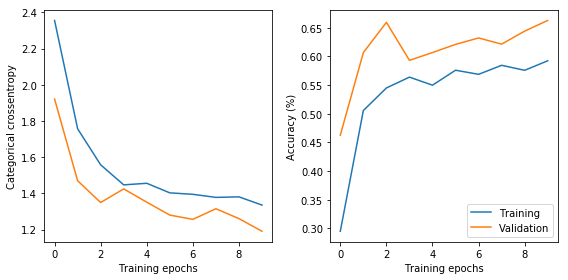

In [50]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].set_xlabel("Training epochs")
ax[0].set_ylabel("Categorical crossentropy")
ax[1].plot(hist.history['acc'])
ax[1].plot(hist.history['val_acc'])
ax[1].set_xlabel("Training epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend(["Training", "Validation"])
plt.tight_layout()

On this short training process, we can see that a very simple model may converge towards interesting results (nothing extraordinary, anyway !).

Considering the very low number of images in the training set, we could expect some overfitting, however that is not visible on this short process. The training set is even smaller, that being a possible explanation of the phenomenon.